## Introduction  
  
The main purpose of this notebook is to show and comparing the results of double DSN versus basic DQN

## Import

In [4]:
from src.agent import DQNAgent, Config
import gym
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Environnement  
  
Both AI will be trained on the same environnement and same numbers of episode to make it easier to compare overall perfomance

In [5]:
env_name = "Taxi-v3"
env = gym.make(env_name)
print('Observation:', env.observation_space.n, env.desc.shape[1], env.desc.shape[0])
print('Action:', env.action_space.n)

Observation: 500 11 7
Action: 6


## Configuration  

Both AI will be configured with hyperparameters who lead to the best result over time

In [22]:
config_dqn = Config(target_update=5, 
                lr=0.01,
                lr_min=0.001,
                lr_decay=50, 
                gamma=0.99,
                loss='mse', 
                memory_size=50000, 
                batch_size=128, 
                eps_start=1, 
                eps_min=0.01, 
                eps_decay=350,
                learning_start=200,
                double_dqn=False)

config_double_dqn = Config(target_update=4, 
                lr=0.01,
                lr_min=0.001,
                lr_decay=50, 
                gamma=0.99,
                loss='mse', 
                memory_size=50000, 
                batch_size=252, 
                eps_start=1, 
                eps_min=0.01, 
                eps_decay=350,
                learning_start=200,
                double_dqn=True)

display(pd.DataFrame([config_dqn, config_double_dqn]))

,target_update,lr,lr_min,lr_decay,gamma,loss,memory_size,batch_size,eps_start,eps_min,eps_decay,learning_start,double_dqn
0,5,0.01,0.001,50,0.99,mse,50000,128,1,0.01,350,200,False
1,4,0.01,0.001,50,0.99,mse,50000,252,1,0.01,350,200,True


## Train both AI

In [15]:
dqn_agent = DQNAgent(env=env, config=config_dqn)
_, dqn_scores = dqn_agent.fit(wandb_log=False, save=False, epochs=1500)

In [23]:
double_dqn_agent = DQNAgent(env=env, config=config_double_dqn)
_, double_dqn_scores = double_dqn_agent.fit(wandb_log=False, save=False, epochs=1500)

### Plotting the time series of scores from the training

In [24]:
df_dqn = pd.Series(dqn_scores[200:900])

In [25]:
df_ddqn = pd.Series(double_dqn_scores[200:900])

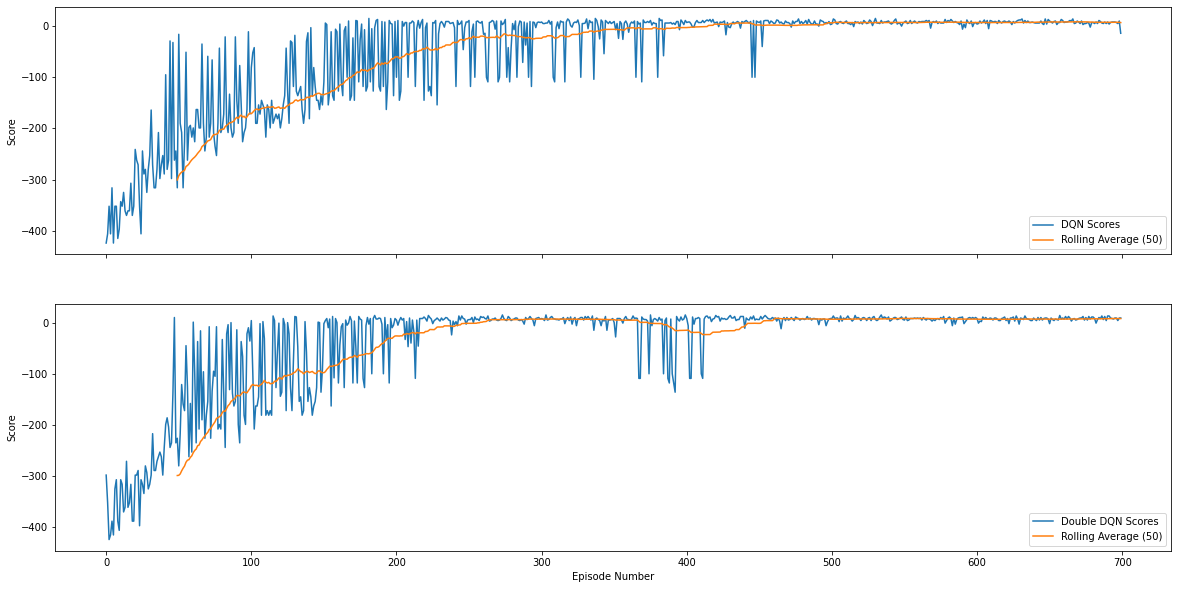

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True, sharey=True)
df_dqn.plot(ax=axes[0], label="DQN Scores")
df_dqn.rolling(window=50).mean().rename("Rolling Average (50)").plot(ax=axes[0])
axes[0].legend()
axes[0].set_ylabel("Score")

df_ddqn.plot(ax=axes[1], label="Double DQN Scores")
df_ddqn.rolling(window=50).mean().rename("Rolling Average (50)").plot(ax=axes[1])
axes[1].legend()
axes[1].set_ylabel("Score")
_ = axes[1].set_xlabel("Episode Number")

### Plotting kernel density 

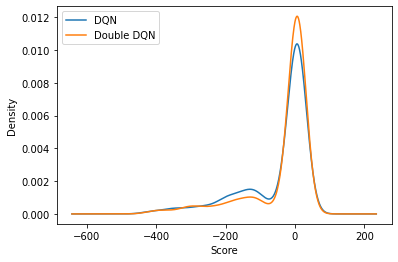

In [27]:
fig, ax = plt.subplots(1,1)
df_dqn.plot(kind="density", ax=ax, label="DQN")
df_ddqn.plot(kind="density", ax=ax, label="Double DQN")
ax.set_xlabel("Score")
_ = ax.legend()

From this plot we can see that the distribution of scores for Double DQN has a slightly higher value on positive score and lower one on negative value, showing that the Double DQN tend to win the game more frequently and with a greatter score.

### Evaluate both AI

In [28]:
def evalAgent(env, agent, n_game=100):
    total_steps, total_rewards, total_penalties = 0, 0, 0
    s, r, p = [], [], []
    for i in range(n_game):
        percent = round(((i + 1) / n_game) * 100)
        print("Loading {0}%".format(percent), end='\r')
        state = env.reset()
        penalties, rewards = 0, 0
        done = False
        step = 0
        while done == False:
            step += 1
            action = agent.get_action(state)
            state, reward, done, _ = env.step(action)
            rewards += reward
            if reward == -10:
                penalties += 1
            if done == True:
                break
        s.append(step)
        r.append(rewards)
        p.append(penalties)
        total_penalties += penalties
        total_rewards += rewards
        total_steps += step
    print(f"Results after {n_game} episodes:")
    print(f"Average timesteps per episode: {total_steps / n_game}")
    print(f"Average penalties per episode: {total_penalties / n_game}")
    print(f"Average rewards per episode: {total_rewards / n_game}")
    return s, r, p

In [33]:
dqn_s, dqn_r, dqn_p = evalAgent(env, dqn_agent, 10000)

Results after 10000 episodes:
Average timesteps per episode: 13.0665
Average penalties per episode: 0.0
Average rewards per episode: 7.9335


In [34]:
ddqn_s, ddqn_r, ddqn_p = evalAgent(env, double_dqn_agent, 10000)

Results after 10000 episodes:
Average timesteps per episode: 13.0686
Average penalties per episode: 0.0
Average rewards per episode: 7.9314


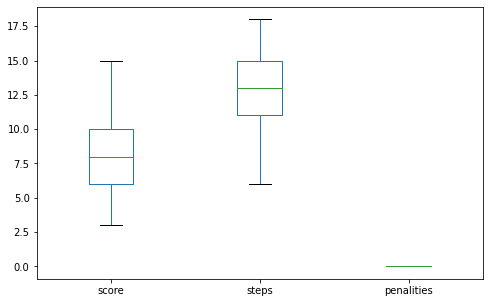

In [35]:
dqn_data = {'score': dqn_r, 'steps': dqn_s, 'penalities': dqn_p}
df_dqn = pd.DataFrame(dqn_data)
df_dqn.index.name = "episode"
_ = df_dqn.plot(figsize=(8,5), kind="box")

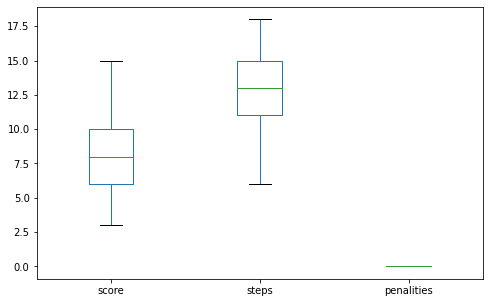

In [36]:
ddqn_data = {'score': ddqn_r, 'steps': ddqn_s, 'penalities': ddqn_p}
df_ddqn = pd.DataFrame(ddqn_data)
df_ddqn.index.name = "episode"
_ = df_ddqn.plot(figsize=(8,5), kind="box")

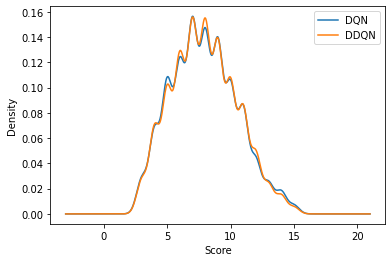

In [37]:
fig, ax = plt.subplots(1,1)
df_dqn['score'].plot(kind="density", ax=ax, label="DQN")
df_ddqn['score'].plot(kind="density", ax=ax, label="DDQN")
ax.set_xlabel("Score")
_ = ax.legend()